This notebook provides statistical tools to evaluate the models quantitatively.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
import os
import sys
import inspect
from pathlib import Path
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = Path(currentdir).parents[1]
sys.path.insert(1, os.path.join(parentdir, 'train'))
sys.path.insert(0, os.path.join(parentdir, 'utils'))

In [4]:
import run
import runner

In [5]:
from text_seqs import TextSequence, TextSequenceCollection

### Load Features

In [5]:
with open("features.txt") as f:
    features = f.read().splitlines()

### Infer & Catch Alignments

In [6]:
predictions, alignments = run.main('config.yml')

In [ ]:
def plot_attention(activations, input_tags = None, output_tags = None):    
   
    features_len = activations.shape[1]
    labels_len = activations.shape[0]

    # Plot the attention map
    plt.clf()
    f = plt.figure(figsize=(25, 20))
    ax = f.add_subplot(1, 1, 1)

    # Add image
    i = ax.imshow(activations, interpolation='nearest', cmap='Blues')

    # Add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # Add labels
    ax.set_yticks(range(labels_len))
    if output_tags != None:
        ax.set_yticklabels(output_tags[:labels_len])

    ax.set_xticks(range(features_len))
    if input_tags != None:
        ax.set_xticklabels(input_tags[:features_len], rotation=90)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    # f.savefig(os.path.join('activation_viz.pdf'), bbox_inches='tight')
    
    plt.savefig("out.svg")
    plt.show()

In [41]:
def drop_repetitive(tags):
    "Drops the same event happening repeatedly one after another."
    
    new_tags = []
    dropped_indices = list()
    prev_tag = None
    for i, tag in enumerate(tags):
        if prev_tag != tag:
            new_tags.append(tag)
        else:
            dropped_indices.append(i)
    
    return dropped_indices, new_tags

In [42]:
def drop_event_type(drop_type, tags, drop_repetitive=True):
    """Drops a list of event type(s) from a list of tags.
    Both `event_type` and ` tags` must be lists."""
    
    new_tags = []
    dropped_indices = list()
    prev_tag = None
    for i, tag in enumerate(tags):
        
        if re.match(r'^ON[0-9]+$', tag):
            tag_type = "ON"
        elif re.match(r'^OFF[0-9]+$', tag):
            tag_type = "OFF"
        elif re.match(r'^SHIFT[0-9]+$', tag):
            tag_type = "SHIFT"
        
        if (drop_repetitive and prev_tag == tag) or tag_type in drop_type:
            dropped_indices.append(i)
        else:
            new_tags.append(tag)
        
        prev_tag = tag
            
    new_tags.append("END")
    
    return dropped_indices, new_tags

In [69]:
drop_repetitive=True
i = 2 # Publish this one
# i = 4, 6 ,8 
# i = 7 # much longer, maybe just show to say – hey, it looks the same
# i = 0 # interesting because for the beginning it is paying attention to events from the end
i = 11 # KEEP THIS, good accompaniment!
# i = 14 # occasionally, we see a parallel shadow
drop_type = [] # a list of event types to exclude from the activations plot

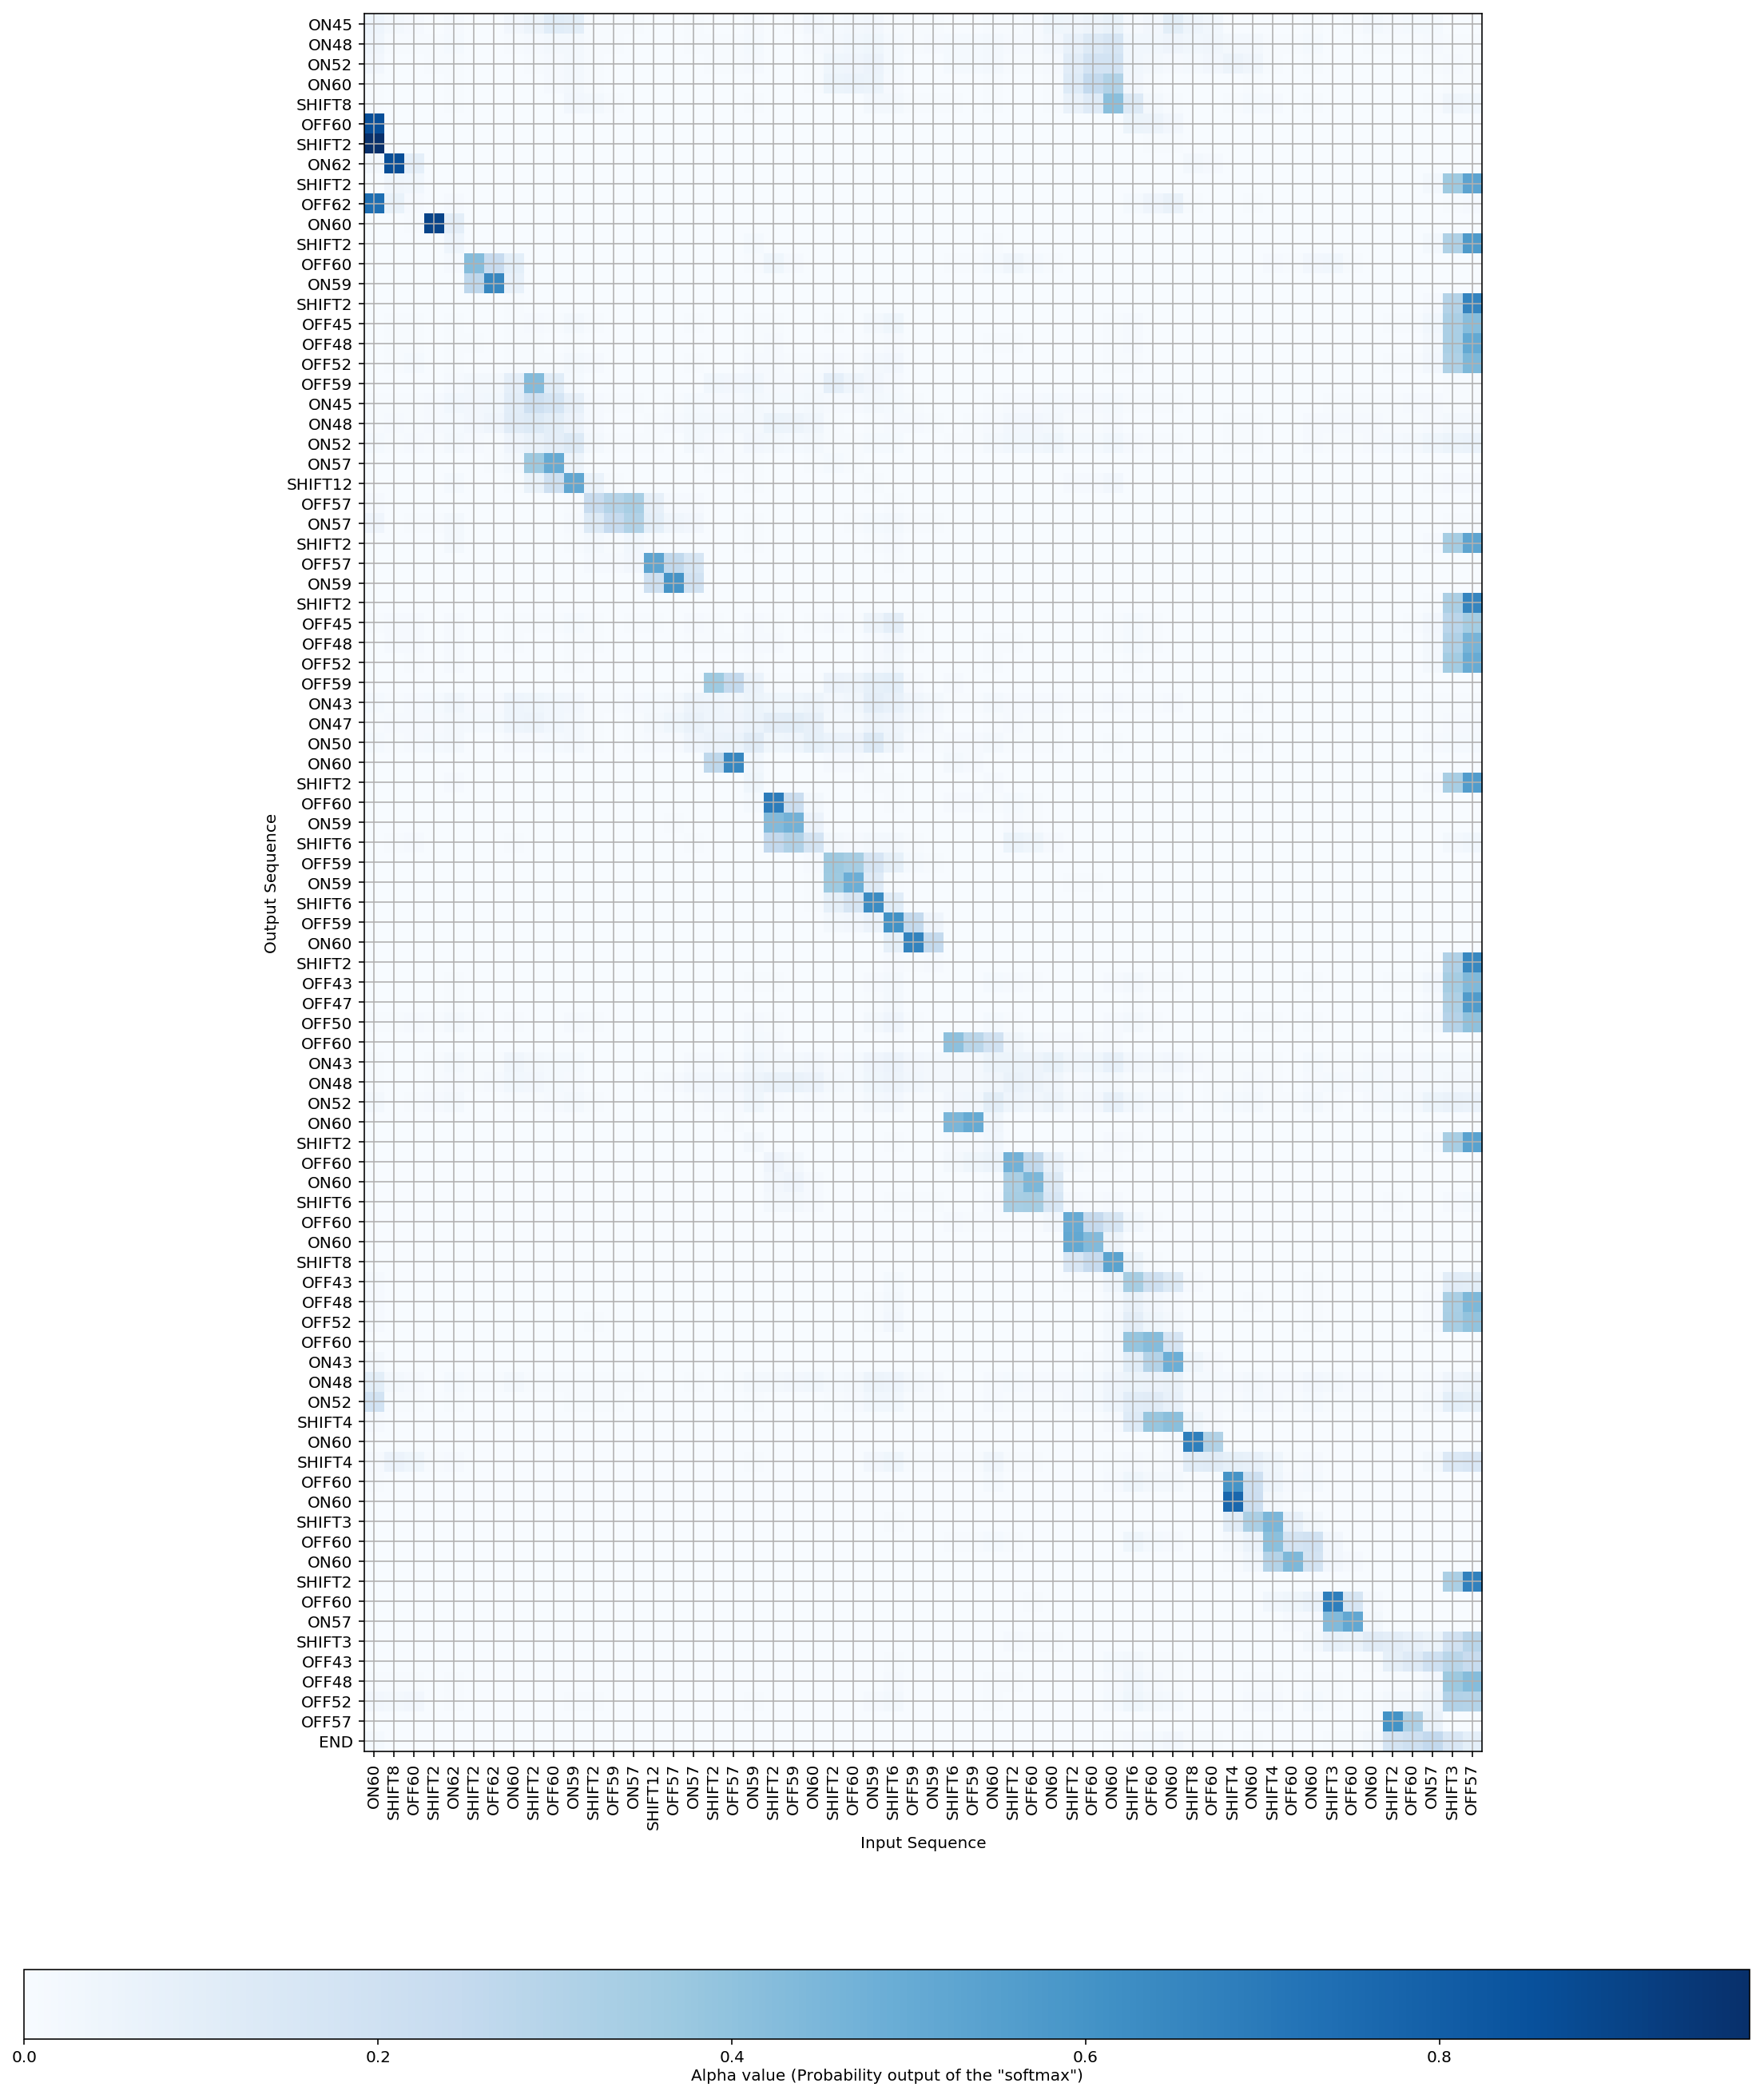

In [70]:
input_tags = features[i].split()
output_tags = predictions[i].split()

activations = alignments[i][0, :, :]

dropped_input_indices, input_tags = drop_event_type(drop_type, input_tags, drop_repetitive)
dropped_output_indices, output_tags = drop_event_type(drop_type, output_tags, drop_repetitive)

activations = np.delete(activations, dropped_input_indices, axis=1)
activations = np.delete(activations, dropped_output_indices, axis=0)

activations = activations[0:len(output_tags), 0:len(input_tags)]

p = plot_attention(activations, input_tags, output_tags)

In [71]:
inputs = TextSequenceCollection('features.txt')
predicted = TextSequenceCollection('features.txt')
predicted.text_seq_list = predictions

In [72]:
inputs.viz(i)
inputs.synth(i)

Loading BokehJS ...

In [73]:
predicted.viz(i)
predicted.synth(i)

Loading BokehJS ...